# Exploratory analysis of data
### Understanding features
This notebook aims to clean, visualize properly and transformatiom data to further apply machine learning techniques

In [1]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib_inline.backend_inline
import seaborn as sns
import matplotlib as mpl
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer
from sklearn.feature_selection import mutual_info_classif

## Import data

In [2]:
train_set = pd.read_csv('data/train.csv')
test_set = pd.read_csv('data/test.csv')
train_set.shape

(8693, 14)

## Clean and organize data
- Drop NA values
- Split Cabin into Deck, Num and Side
- Add TotalCost column
- Explore data


In [3]:
for feature in train_set.columns:
    print(f"{feature} has {train_set[feature].isnull().sum()}")

PassengerId has 0
HomePlanet has 201
CryoSleep has 217
Cabin has 199
Destination has 182
Age has 179
VIP has 203
RoomService has 181
FoodCourt has 183
ShoppingMall has 208
Spa has 183
VRDeck has 188
Name has 200
Transported has 0


In [4]:

def fill_na(df, method='mean'):
    """
    Fill missing values in a DataFrame without replacing the original data.
    
    Parameters:
    - df: pd.DataFrame, the original DataFrame
    - method: str, the method to use for filling missing values ('mean', 'median', 'mode', 'ffill', 'bfill')
    
    Returns:
    - pd.DataFrame, a new DataFrame with missing values filled
    """
    df_filled = df.copy()
    
    if method == 'mean':
        fill_values = {col: df_filled[col].mean() for col in df_filled.columns if df_filled[col].dtype in ['float64', 'int64']}
        print(fill_values)
        df_filled.fillna(value=fill_values, inplace=True)
    
    elif method == 'median':
        fill_values = {col: df_filled[col].median() for col in df_filled.columns if df_filled[col].dtype in ['float64', 'int64']}
        print(fill_values)
        df_filled.fillna(value=fill_values, inplace=True)
    
    elif method == 'mode':
        fill_values = {col: df_filled[col].mode()[0] for col in df_filled.columns}
        print(fill_values)

        df_filled.fillna(value=fill_values, inplace=True)
    
    elif method == 'ffill' or method == 'bfill':
        df_filled.fillna(method=method, inplace=True)
    
    else:
        raise ValueError("Invalid method. Choose from 'mean', 'median', 'mode', 'ffill', 'bfill'.")
    
    return df_filled

In [5]:
# Drop NA values

print(train_set.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None


In [6]:
# Split Cabin column
train_set[['Deck', 'Num', 'Side']] = train_set.pop('Cabin').str.split('/', expand=True)
train_set[['Group','Person']] = train_set['PassengerId'].str.split('_', expand=True)

In [7]:
# Create TotalCost
train_set['TotalCost'] = train_set['RoomService'] + train_set['FoodCourt'] + train_set[ 'ShoppingMall'] + train_set[ 'Spa'] + train_set[ 'VRDeck']

In [8]:
# Organize column order
train_set = train_set[['PassengerId','Group','Person', 'HomePlanet', 'CryoSleep', 'Deck', 'Num', 'Side', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','TotalCost','Name', 'Transported']]

In [9]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   Group         8693 non-null   object 
 2   Person        8693 non-null   object 
 3   HomePlanet    8492 non-null   object 
 4   CryoSleep     8476 non-null   object 
 5   Deck          8494 non-null   object 
 6   Num           8494 non-null   object 
 7   Side          8494 non-null   object 
 8   Destination   8511 non-null   object 
 9   Age           8514 non-null   float64
 10  VIP           8490 non-null   object 
 11  RoomService   8512 non-null   float64
 12  FoodCourt     8510 non-null   float64
 13  ShoppingMall  8485 non-null   float64
 14  Spa           8510 non-null   float64
 15  VRDeck        8505 non-null   float64
 16  TotalCost     7785 non-null   float64
 17  Name          8493 non-null   object 
 18  Transported   8693 non-null 

Duplicated names probably are different person


In [10]:
train_set[train_set.Name.duplicated(keep=False)].sort_values('Name').tail(6)

,PassengerId,Group,Person,HomePlanet,CryoSleep,Deck,Num,Side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalCost,Name,Transported
8613,9194_01,9194,01,NaN,False,E,603,S,55 Cancri e,53.0,False,0.0,4017.0,0.0,13.0,3147.0,7177.0,NaN,False
8629,9205_02,9205,02,Europa,True,B,300,P,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,0.0,0.0,0.0,NaN,True
8631,9208_01,9208,01,Earth,True,G,1485,S,TRAPPIST-1e,35.0,False,0.0,0.0,0.0,0.0,0.0,0.0,NaN,True
8636,9218_01,9218,01,Europa,True,B,353,S,55 Cancri e,43.0,False,0.0,0.0,0.0,0.0,0.0,0.0,NaN,True
8652,9230_01,9230,01,Europa,False,C,342,S,TRAPPIST-1e,36.0,True,0.0,5600.0,715.0,2868.0,971.0,10154.0,NaN,True
8664,9246_01,9246,01,Earth,NaN,G,1490,S,TRAPPIST-1e,32.0,False,0.0,0.0,0.0,0.0,0.0,0.0,NaN,True


# Visualize and transform data

In [11]:
train_set.sort_values('PassengerId').head(10)

,PassengerId,Group,Person,HomePlanet,CryoSleep,Deck,Num,Side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalCost,Name,Transported
0,0001_01,0001,01,Europa,False,B,0,P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,0002,01,Earth,False,F,0,S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,736.0,Juanna Vines,True
2,0003_01,0003,01,Europa,False,A,0,S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,10383.0,Altark Susent,False
3,0003_02,0003,02,Europa,False,A,0,S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,5176.0,Solam Susent,False
4,0004_01,0004,01,Earth,False,F,1,S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1091.0,Willy Santantines,True
5,0005_01,0005,01,Earth,False,F,0,P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,774.0,Sandie Hinetthews,True
6,0006_01,0006,01,Earth,False,F,2,S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,1584.0,Billex Jacostaffey,True
7,0006_02,0006,02,Earth,True,G,0,S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,NaN,Candra Jacostaffey,True
8,0007_01,0007,01,Earth,False,F,3,S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,1018.0,Andona Beston,True
9,0008_01,0008,01,Europa,True,B,1,P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


### Distribution of data
Transformation is needed for numerical data

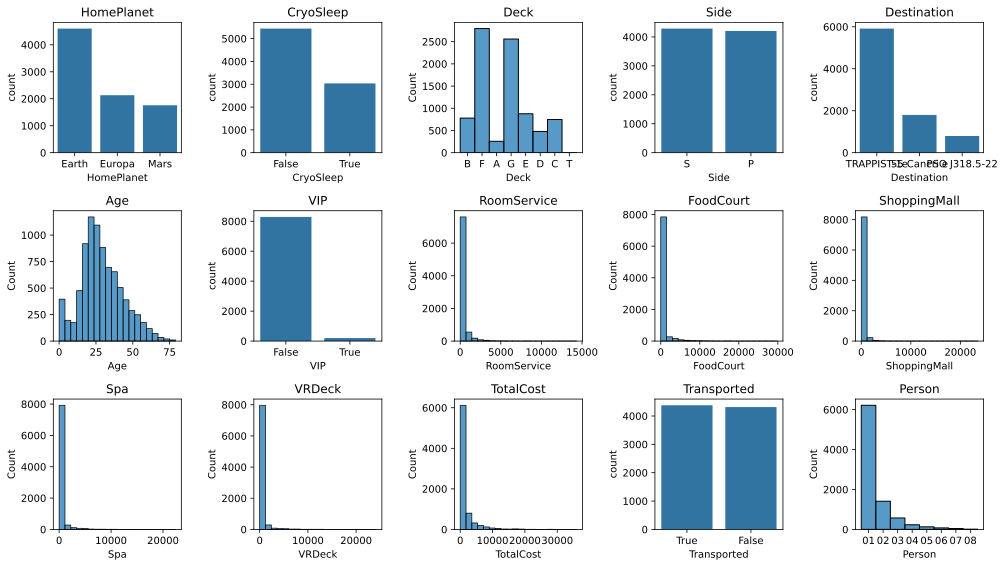

In [12]:
fig,ax = plt.subplots(3,5,figsize=(14,8))
axes = ax.flatten()
fig.tight_layout()
columns_plot = ['HomePlanet','CryoSleep','Deck','Side','Destination','Age','VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalCost','Transported','Person']

for i,column in enumerate(columns_plot):
    if len(train_set[column].unique()) < 8:

        sns.countplot(data=train_set, x=column, order=train_set[column].value_counts().index, ax=axes[i])
        #train_set[column].value_counts().plot.pie(autopct='%1.1f%%',ax=axes[i])
        axes[i].set_title(column)
        continue
    sns.histplot(train_set[column], ax=axes[i],bins=20)
    axes[i].set_title(column)
fig.tight_layout()

Testing transformation for numerical values

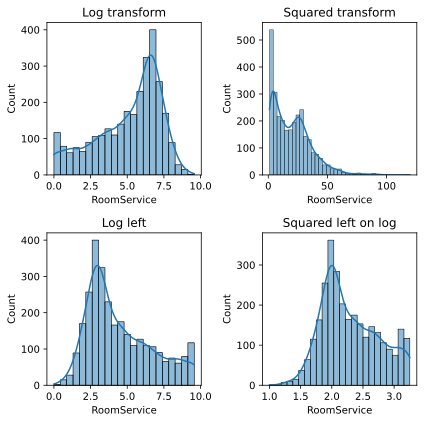

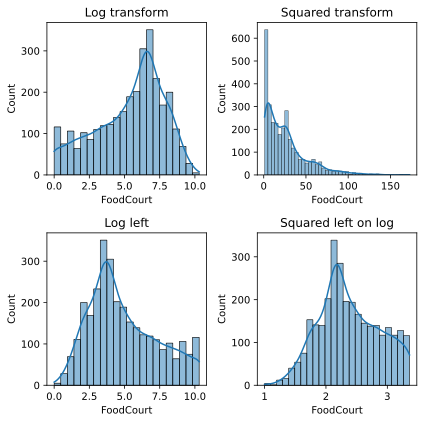

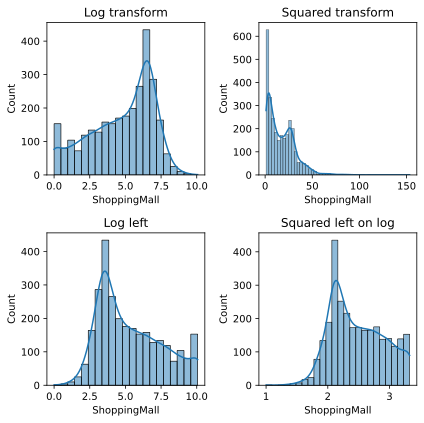

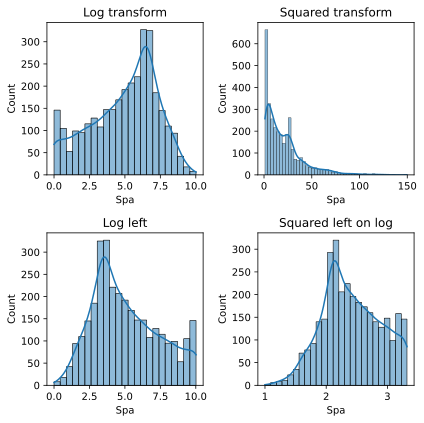

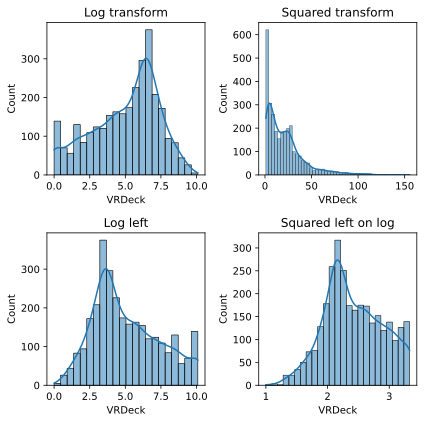

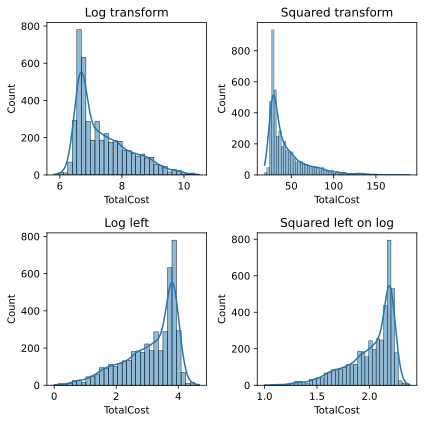

In [13]:

numerical_columns =['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalCost']
eps = 1e-5

for column in numerical_columns:
    fig,ax = plt.subplots(2,2,figsize=(6,6))
    axes = ax.flatten()

    log_col = np.log(train_set[train_set[column] != 0][column])
    
    squared_col = np.sqrt(train_set[train_set[column] != 0][column])
    
    left_log_col = np.log(max(train_set[train_set[column] != 0][column])+1) - np.log(train_set[train_set[column] != 0][column])
    
    left_squared_log_col = np.sqrt(left_log_col)

    sns.histplot(np.log(train_set[train_set[column] != 0][column]), ax=axes[0], kde=True)
    axes[0].set_title('Log transform')
    sns.histplot(np.sqrt(train_set[train_set[column] != 0][column]), ax=axes[1], kde=True)
    axes[1].set_title('Squared transform')
    sns.histplot(np.log(max(train_set[train_set[column] != 0][column])+1) - np.log(train_set[train_set[column] != 0][column]), ax=axes[2], kde=True)
    axes[2].set_title('Log left')
    sns.histplot(np.sqrt(max(np.log(train_set[train_set[column] != 0][column])+1) - np.log(train_set[train_set[column] != 0][column])), ax=axes[3], kde=True)
    axes[3].set_title('Squared left on log')

    fig.tight_layout()

Transform numerical values to acquire a smoother distribution

In [14]:

# Define the transform function
def transform(series):
    max_val = series.max()
    left_log_col = np.log(max_val + 1) - np.log(series)
    left_squared_log_col = np.sqrt(left_log_col)
    return left_squared_log_col

for column in numerical_columns:
    left_log_col = np.where(train_set[column] != 0, transform(train_set[column]),train_set[column]);
    train_set[column] = np.sqrt(left_log_col)

c:\Users\artur\Desktop\lneoc\pibic_lneoc\deep_learning\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Distribution after transformation

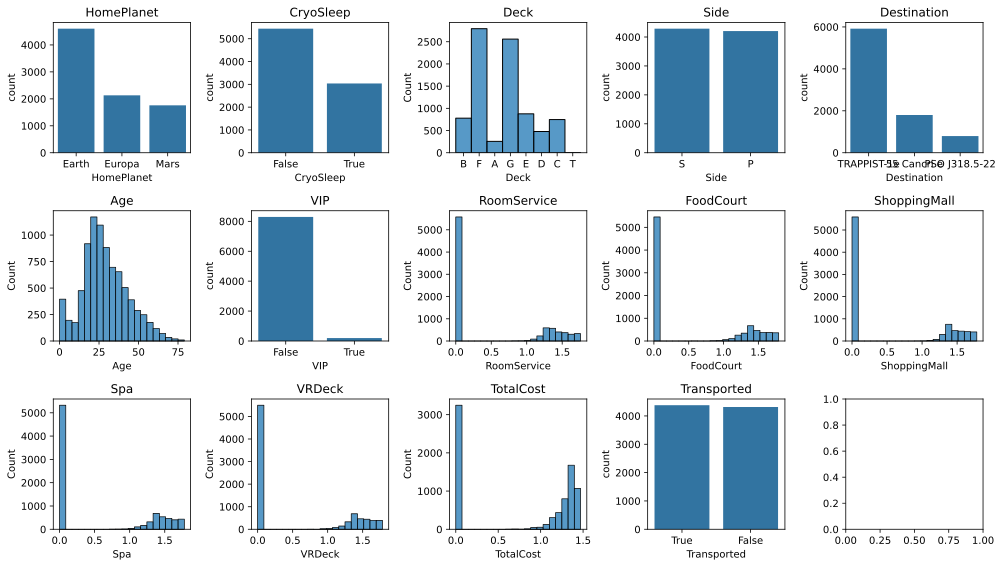

In [15]:
fig,ax = plt.subplots(3,5,figsize=(14,8))
axes = ax.flatten()
fig.tight_layout()
columns_plot = ['HomePlanet','CryoSleep','Deck','Side','Destination','Age','VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalCost','Transported']

for i,column in enumerate(columns_plot):
    if len(train_set[column].unique()) < 8:

        sns.countplot(data=train_set, x=column, order=train_set[column].value_counts().index, ax=axes[i])
        #train_set[column].value_counts().plot.pie(autopct='%1.1f%%',ax=axes[i])
        axes[i].set_title(column)
        continue
    sns.histplot(train_set[column], ax=axes[i],bins=20)
    axes[i].set_title(column)
fig.tight_layout()

### Target proportion in categorical features

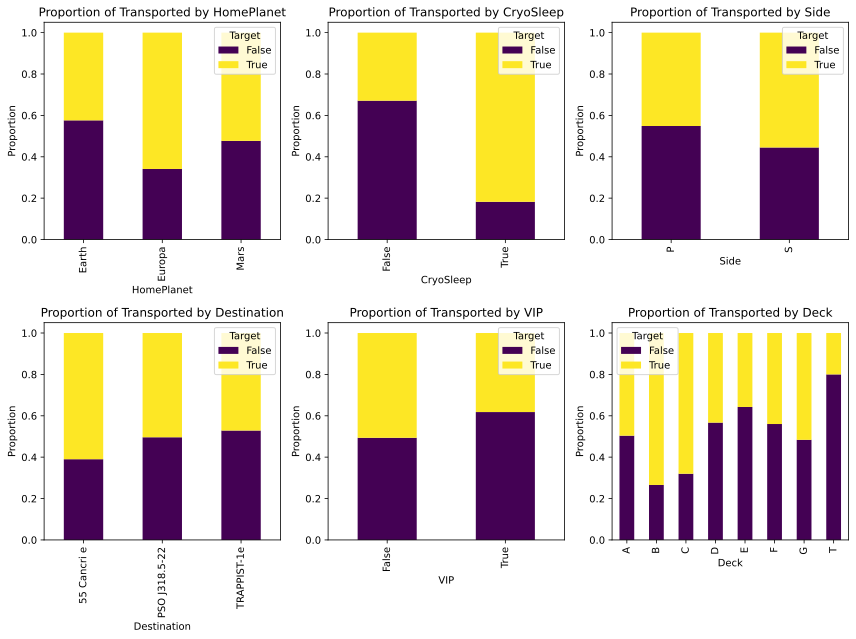

In [16]:
columns_plot = ['HomePlanet','CryoSleep','Side','Destination','VIP','Deck']

fig,ax = plt.subplots(2,3,figsize=(12,9))
axes = ax.flatten()
for i,column in enumerate(columns_plot):
        
    # Calculate the proportions for each category and target
    proportion_data = train_set.groupby([column, 'Transported']).size().unstack(fill_value=0)
    proportion_data = proportion_data.div(proportion_data.sum(axis=1), axis=0)

    # Plot normalized stacked bar plot
    proportion_data.plot(kind='bar', stacked=True, colormap='viridis',ax=axes[i])
    axes[i].set_title(f'Proportion of Transported by {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Proportion')
    axes[i].legend(title='Target')

fig.tight_layout()

### KDE of numerical features

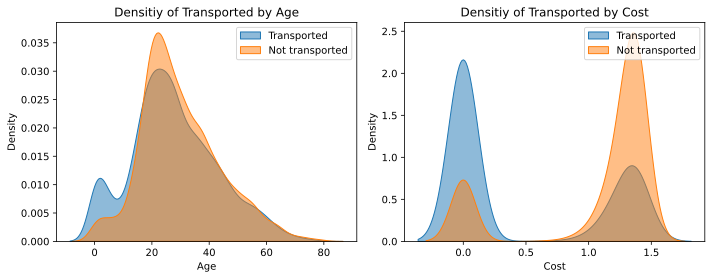

In [17]:
fig,ax = plt.subplots(1,2,figsize=(10, 4))
axes = ax.flatten()

sns.kdeplot(data=train_set[train_set['Transported'] == 1], x='Age', fill=True, label='Transported', alpha=0.5,ax=axes[0])
sns.kdeplot(data=train_set[train_set['Transported'] == 0], x='Age', fill=True, label='Not transported', alpha=0.5,ax=axes[0])
axes[0].set_title('Densitiy of Transported by Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Density')
axes[0].legend()


sns.kdeplot(data=train_set[train_set['Transported'] == 1], x='TotalCost', fill=True, label='Transported', alpha=0.5,ax=axes[1])
sns.kdeplot(data=train_set[train_set['Transported'] == 0], x='TotalCost', fill=True, label='Not transported', alpha=0.5,ax=axes[1])
axes[1].set_title('Densitiy of Transported by Cost')
axes[1].set_xlabel('Cost')
axes[1].set_ylabel('Density')
axes[1].legend()
fig.tight_layout()

### Exploring correlation on numerical features

In [18]:
correlation_matrix = train_set[['Num', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','TotalCost','Transported']].corr()
print(correlation_matrix['Transported'].sort_values(ascending=False))


Transported     1.000000
Num            -0.045097
Age            -0.075026
FoodCourt      -0.259551
ShoppingMall   -0.281539
VRDeck         -0.316902
Spa            -0.324641
RoomService    -0.334127
TotalCost      -0.474103
Name: Transported, dtype: float64


### Exploring correlation on categorical features

In [19]:
from scipy.stats import chi2_contingency

def chi_square_test(df, feature, target):
    contingency_table = pd.crosstab(df[feature], df[target])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    return chi2, p

categorical_feat = ['HomePlanet','CryoSleep','Side','Destination','VIP','Deck']

for column in categorical_feat:
    chi2, p = chi_square_test(train_set, column, 'Transported')
    print(f"{column} - Chi2: {chi2}, p-value: {p}")
    alpha = 0.05
    if p < alpha:
        print(f"There is a significant association between {column} and Transported.")
        print()

HomePlanet - Chi2: 324.9013834000382, p-value: 2.809059985251311e-71
There is a significant association between HomePlanet and Transported.

CryoSleep - Chi2: 1859.6127129888841, p-value: 0.0
There is a significant association between CryoSleep and Transported.

Side - Chi2: 91.0595970786772, p-value: 1.3940936254458288e-21
There is a significant association between Side and Transported.

Destination - Chi2: 106.39215684982227, p-value: 7.892901466137099e-24
There is a significant association between Destination and Transported.

VIP - Chi2: 11.542020738162797, p-value: 0.0006804064556968345
There is a significant association between VIP and Transported.

Deck - Chi2: 392.2880411997481, p-value: 1.0743307258871414e-80
There is a significant association between Deck and Transported.



# Data preparation for model
- Compacted feature transform function
- Mutual information calculation
- File upload

In [20]:

def features_transform(df: pd.DataFrame) -> pd.DataFrame:
    
    numerical_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalCost']
    object2int_columns = ['Num', 'Group', 'Person']
    categorical_feat = ['HomePlanet','CryoSleep','Destination','VIP','Name','Side','Deck']

    # Cabin split
    df[['Deck', 'Num', 'Side']] = df.pop('Cabin').str.split('/', expand=True)
    df[['Group', 'Person']] = df['PassengerId'].str.split('_', expand=True)

    imp= KNNImputer(n_neighbors=5) 

    df1_imp = imp.fit_transform(df[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','Num', 'Person']])
    df[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','Num', 'Person']] = df1_imp

    df[categorical_feat] = fill_na(df[categorical_feat],method='mode')

    for col in object2int_columns:
        df[col] = df[col].astype(int)

    # Total cost feature
    df['TotalCost'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']

    # Log squared transform
    #for column in numerical_columns:
    #    df[column] = np.where(df[column] != 0, transform(df[column]), df[column])
#    for feature in df.columns:
#       print(f"{feature} has {df[feature].isnull().sum()}")
    
    return df
le = LabelEncoder()
def feature_encode(df: pd.DataFrame) -> pd.DataFrame:
    # List of features to encode
    feats2hotencode = ['HomePlanet', 'Destination', 'Deck']
    # Perform one-hot encoding
    df = pd.get_dummies(df, columns=feats2hotencode)
    feats2encode = ['CryoSleep','VIP','Side']
    for feat in feats2encode:
        df[feat] = le.fit_transform(df[feat])
    return df


# Compact pipeline and storing

In [28]:
train_set = pd.read_csv('data/train.csv')
test_set = pd.read_csv('data/test.csv')

LABELS_SUB = test_set['PassengerId']

test_set = features_transform(test_set)
test_set = feature_encode(test_set)

train_set = features_transform(train_set)
train_set = feature_encode(train_set)

Y = train_set['Transported'].to_numpy()
x_labels = list(train_set.columns)
x_labels.remove('Transported')
x_labels.remove('Name')
x_labels.remove('PassengerId')

X_test = test_set[x_labels].astype(float).to_numpy()
X = train_set[x_labels].astype(float).to_numpy()

for i in range(len(x_labels)):
    print(x_labels[i],': ',X[:,i])

np.savez_compressed('./data/train_curated',train=X,target=Y,feats=np.array(train_set.columns))
np.savez_compressed('./data/test_curated',test=X_test,labels=LABELS_SUB)

{'HomePlanet': 'Earth', 'CryoSleep': False, 'Destination': 'TRAPPIST-1e', 'VIP': False, 'Name': 'Berta Barnolderg', 'Side': 'S', 'Deck': 'F'}


C:\Users\artur\AppData\Local\Temp\ipykernel_17044\425181689.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filled.fillna(value=fill_values, inplace=True)


{'HomePlanet': 'Earth', 'CryoSleep': False, 'Destination': 'TRAPPIST-1e', 'VIP': False, 'Name': 'Alraium Disivering', 'Side': 'S', 'Deck': 'F'}
CryoSleep :  [0. 0. 0. ... 0. 0. 0.]
Age :  [39. 24. 58. ... 26. 32. 44.]
VIP :  [0. 0. 1. ... 0. 0. 0.]
RoomService :  [  0. 109.  43. ...   0.   0. 126.]
FoodCourt :  [   0.    9. 3576. ...    0. 1049. 4688.]
ShoppingMall :  [   0.   25.    0. ... 1872.    0.    0.]
Spa :  [0.000e+00 5.490e+02 6.715e+03 ... 1.000e+00 3.530e+02 0.000e+00]
VRDeck :  [   0.   44.   49. ...    0. 3235.   12.]
Num :  [   0.    0.    0. ... 1500.  608.  608.]
Side :  [0. 1. 1. ... 1. 1. 1.]
Group :  [1.000e+00 2.000e+00 3.000e+00 ... 9.279e+03 9.280e+03 9.280e+03]
Person :  [1. 1. 1. ... 1. 1. 2.]
TotalCost :  [    0.   736. 10383. ...  1873.  4637.  4826.]
HomePlanet_Earth :  [0. 1. 0. ... 1. 0. 0.]
HomePlanet_Europa :  [1. 0. 1. ... 0. 1. 1.]
HomePlanet_Mars :  [0. 0. 0. ... 0. 0. 0.]
Destination_55 Cancri e :  [0. 0. 0. ... 0. 1. 0.]
Destination_PSO J318.5-22 : 

C:\Users\artur\AppData\Local\Temp\ipykernel_17044\425181689.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filled.fillna(value=fill_values, inplace=True)


# Mutual info classification

In [22]:
Mutual=mutual_info_classif(X,Y)
S=pd.Series(Mutual)
S.index=x_labels
S.sort_values(ascending=False)

TotalCost                    0.128310
CryoSleep                    0.122525
Spa                          0.075230
RoomService                  0.067745
VRDeck                       0.063196
ShoppingMall                 0.047045
FoodCourt                    0.040763
Group                        0.021710
Num                          0.016322
HomePlanet_Earth             0.012280
Destination_TRAPPIST-1e      0.010299
Deck_G                       0.010186
HomePlanet_Europa            0.009360
Deck_E                       0.008592
Deck_B                       0.008211
Deck_T                       0.007341
Deck_D                       0.006944
Age                          0.006917
Destination_55 Cancri e      0.006202
Side                         0.005196
Deck_F                       0.004084
Deck_C                       0.003606
Deck_A                       0.003341
Person                       0.002343
VIP                          0.001758
Destination_PSO J318.5-22    0.000806
HomePlanet_M

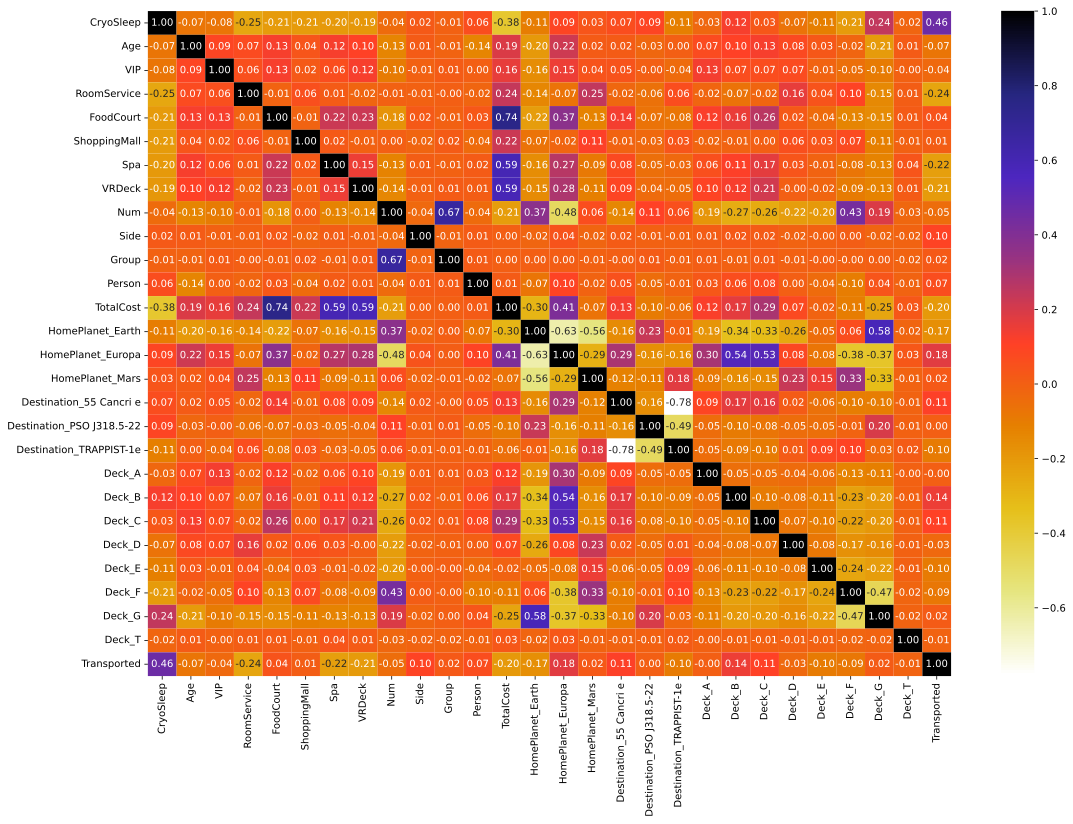

In [23]:
labels2corr = x_labels
labels2corr.append('Transported')
dfcorr = train_set.copy(deep=True)
dfcorr['Transported'] = Y

plt.figure(figsize=(18,12))
cor=dfcorr[labels2corr].corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.CMRmap_r,fmt=".2f")
plt.show()